In [1]:
%%capture
from threeML import Powerlaw
from cosipy import FastTSMap, SpacecraftFile
from cosipy.response import FullDetectorResponse
import astropy.units as u
from histpy import Histogram
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from pathlib import Path
from mhealpy import HealpixMap
from matplotlib import pyplot as plt
import sys

# Fit the GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

## Define a powerlaw spectrum

In [2]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

## Read data, background model and orientation

In [3]:
# open bkg model

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Bkg_2s_model.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

In [4]:
# Read GRB orientation from file
ori = SpacecraftFile.parse_from_file("../../cosipy/test_data/GRB_Orientation.ori")

## Start TS map fit

In [5]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/Continuum_Flat_100to10000keV_10logEbins_HealPix03.binnedimaging.imagingresponse_nside8.area.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

In [6]:
# get a list of hypothesis coordinates to fit. The models will be put on these 
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [7]:
# This is the actual parallel fit
# It uses as much as cores available now  ---> Please let me know if it significantly slow down your machine.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING")

The time used for the parallel TS map computation is 3.1496909419695536 minutes


## Plot the fitted TS map

In [13]:
ts_array = np.array(ts_results)[:,0:9]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

Text(0.5, 1.0, 'TS Map')

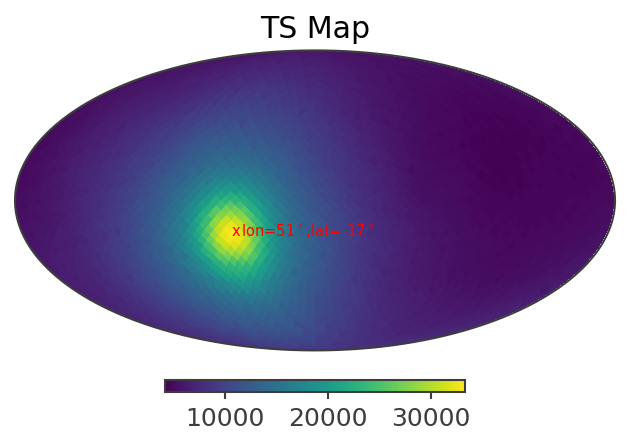

In [14]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("TS Map")

## Plot the iteration map

6.160807291666667


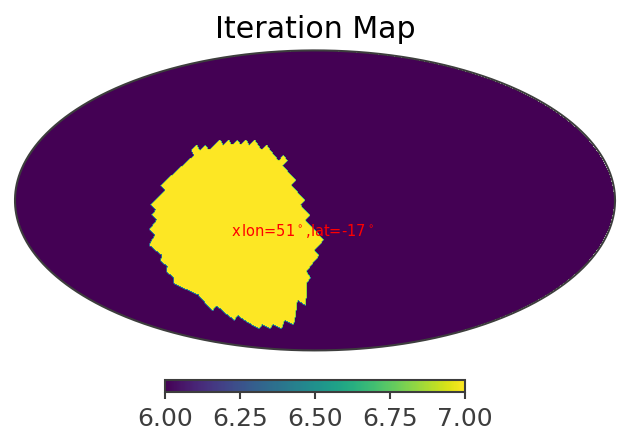

In [23]:
array = ts_array[:,5] # get the array of iteration
avg_iter = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("Iteration Map")
print(avg_iter)

## Plot the elapsed time map

2.0695886713607856


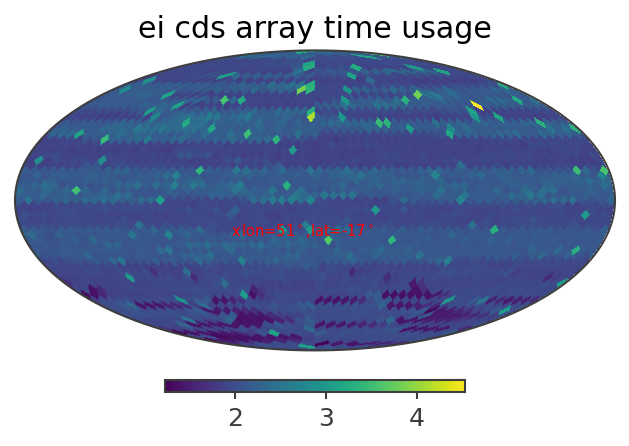

In [26]:
array = ts_array[:,6] # get the array of ei cds time
avg_ei_cds_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("ei cds array time usage")
print(avg_ei_cds_time)

0.193642971261094


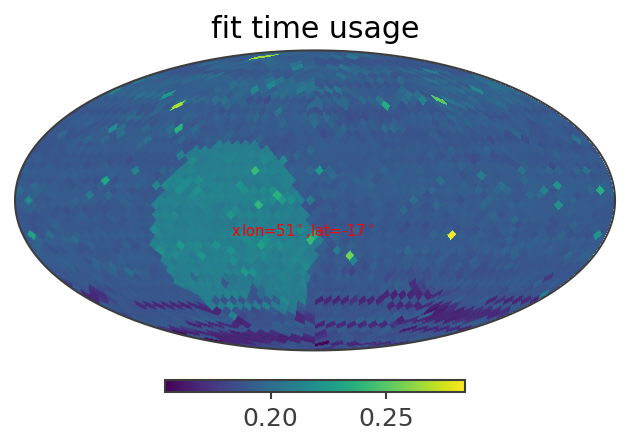

In [27]:
array = ts_array[:,7] # get the array of fit time
avg_fit_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("fit time usage")
print(avg_fit_time)

2.2643727981485426


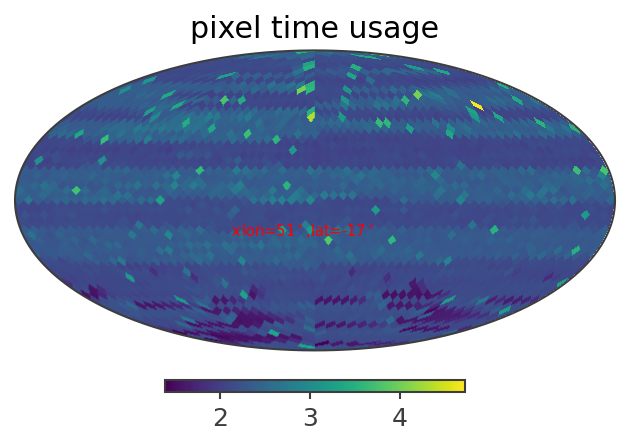

In [29]:
array = ts_array[:,8] # get the array of time per pixel
avg_time_per_pixel = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("pixel time usage")
print(avg_time_per_pixel)

# Fit Crab using the Compton Data Space (CDS) in galactic coordinates

## Process data

In [2]:
# get the binned Crab data
# Because the binned Crab data is too large (~152), so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Sources". If you download the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the Crab data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Crab_galactic_CDS",
                         psichi_binning = "galactic")

# After you generate the binned data files, it should be saved to the same directory of this notebook

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [3]:
# get the binned background data
# Because the binned background data is too large (~334M), so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Backgrounds". If you download the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the background data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Albedo_galactic_CDS",
                         psichi_binning = "galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [4]:
#import tracemalloc

#tracemalloc.start()

In [21]:
#tracemalloc.get_object_traceback(bkg_model)

<Traceback (<Frame filename='/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/histpy/histogram.py' lineno=986>,)>

In [22]:
# open bkg model

bkg_model = Histogram.open("Albedo_galactic_CDS.hdf5")  # please make sure you adjust the path to the files by yourself.
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("Crab_galactic_CDS.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

# here the background added to the source is the same as the bkg model since they are simulations, thus we know the background very well.
bkg_original = Histogram.open("Albedo_galactic_CDS.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

#del data_used

In [36]:
# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')

# print("[ Top 10 ]")
# for stat in top_stats[:10]:
#     print(stat)

[ Top 10 ]
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/histpy/histogram.py:1895: size=3367 MiB, count=12, average=281 MiB
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/histpy/histogram.py:1896: size=842 MiB, count=8, average=105 MiB
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/histpy/axis.py:66: size=487 MiB, count=44, average=11.1 MiB
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/sparse/_coo/core.py:1284: size=24.1 MiB, count=12, average=2054 KiB
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/sparse/_umath.py:511: size=8757 KiB, count=4, average=2189 KiB
/home/sheng2/Applications/conda_envs/cosipy_spacecraftfile_new/lib/python3.10/site-packages/sparse/_coo/core.py:1285: size=8216 KiB, count=8, average=1027 KiB
/home/sheng2/Applications/conda_envs/cosipy_spa

Text(0, 0.5, 'Counts')

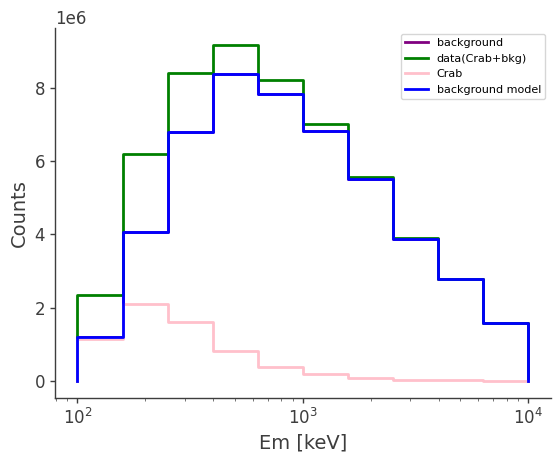

In [5]:
# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "background", color = "purple")
#data.project("Em").draw(ax, label = "data", color = "green")
data_used.project("Em").draw(ax, label = "data(Crab+bkg)", color = "green")
signal.project("Em").draw(ax, label = "Crab", color = "pink")
bkg_model.project("Em").draw(ax, label = "background model", color = "blue")

ax.legend()
ax.set_xscale("log")
ax.set_ylabel("Counts")

## Start TS map fit

In [30]:
# define a powerlaw spectrum
index = -3
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

In [31]:
# the response file is available on wasabi  --> Please let me know if you need the command line to download it
response_path = Path("/zfs/astrohe/yong/COSI/cosipy_workshop2023/DC2/Responses/PointSourceReponse/psr_gal_DC2.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [32]:
# get a list of hypothesis coordinates to fit. The model will be put on these coordinates to generated the expected counts
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [33]:
# This is the actual parallel fit
# You can configure the number of cores now.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [1,2], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

The time used for the parallel TS map computation is 0.5797204852104187 minutes


## Plot results

In [34]:
ts_array = np.array(ts_results)[:,0:9]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

Text(184.5551, -5.7877, '   Crab')

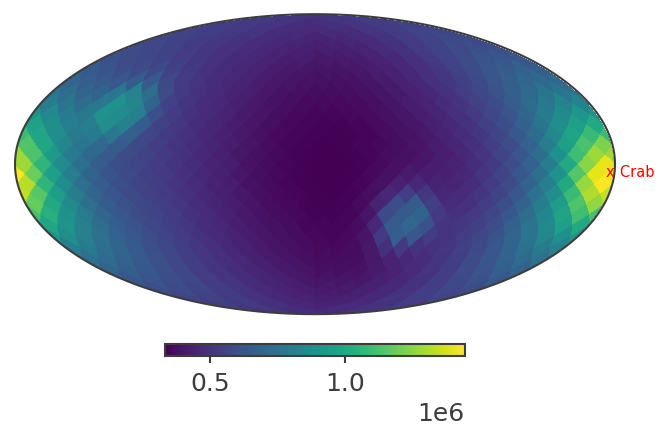

In [35]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
ax.text(184.5551, -05.7877, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(184.5551, -05.7877, fr"   Crab", size = 7, transform = ax.get_transform('galactic'), color = "red")

## Plot the iteration map

4.947916666666667


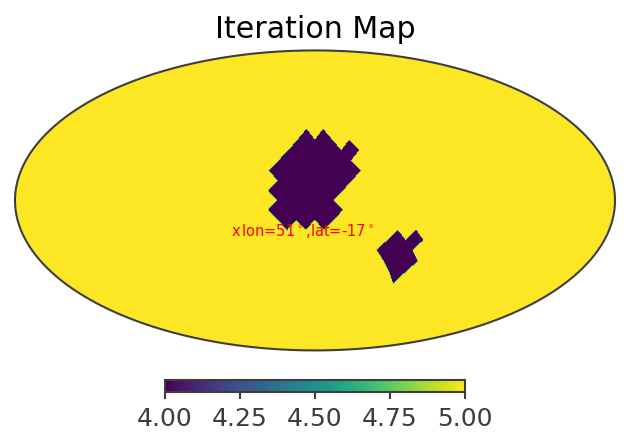

In [36]:
array = ts_array[:,5] # get the array of iteration
avg_iter = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("Iteration Map")
print(avg_iter)

## Plot the elapsed time map

0.14726191953135034


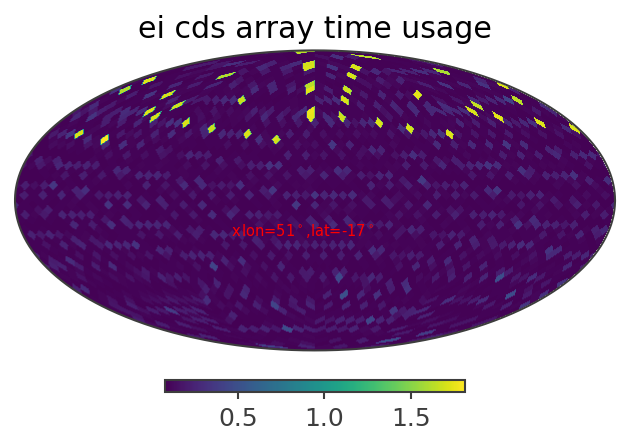

In [37]:
array = ts_array[:,6] # get the array of ei cds time
avg_ei_cds_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("ei cds array time usage")
print(avg_ei_cds_time)

0.2639058045266817


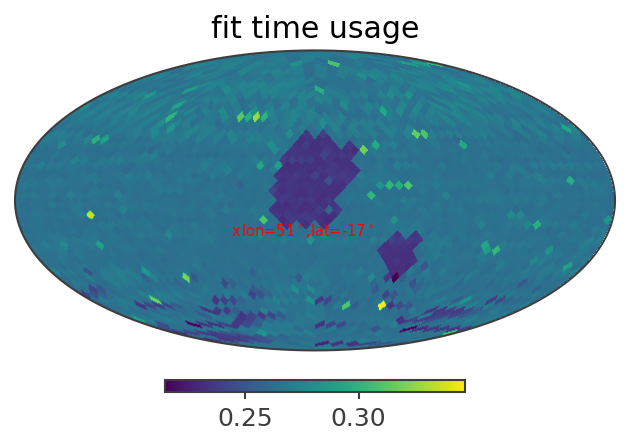

In [38]:
array = ts_array[:,7] # get the array of fit time
avg_fit_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("fit time usage")
print(avg_fit_time)

0.4120916190246741


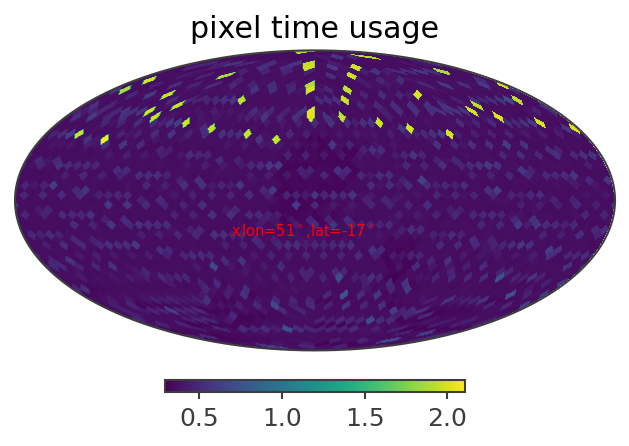

In [39]:
array = ts_array[:,8] # get the array of time per pixel
avg_time_per_pixel = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("pixel time usage")
print(avg_time_per_pixel)

# Fit the GRB using the Compton Data Space (CDS) in galactic coordinates
## **NOTE: This is deprecated, do not run. Keep it for reference if needed in the furture.**

## Define a powerlaw spectrum

In [26]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

## Read data, background model and orientation

In [28]:
# open bkg model

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2hr_galactic.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])/3600

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB_galactic.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s_galactic.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

In [29]:
# get orientation
# Note this orientation is hard-coded for this specific GRB

time = Time(np.array([1835481433.0, 1835481433.5, 1835481434.0, 1835481434.5, 1835481435.0]), format="unix")

x_pointings = SkyCoord(b=[53.30823215719789, 53.30823215719789, 53.25629494101732, 53.25629494101732, 53.20436773279772]*u.deg,
                       l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg,
                       frame = "galactic")

z_pointings = SkyCoord(l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg, 
                       b = [-36.69176784280211, -36.69176784280211, -36.74370505898268, -36.74370505898268, -36.79563226720228]*u.deg,
                       frame = "galactic")

ori = SpacecraftFile(time = time, x_pointings = x_pointings, z_pointings = z_pointings)

## Start TS map fit

In [30]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [31]:
# get a list of hypothesis coordinates to fit. The models will be put on these coordinates
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [32]:
# This is the actual parallel fit
# It uses as much as cores available now  ---> Please let me know if it significantly slow down your machine.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING")

The time used for the parallel TS map computation is 1.798968990643819 minutes


## Plot the fitted TS map

In [33]:
ts_results

[[0, 13473.45513282079, 52.3137819622534, 0.6184566698227567, False],
 [1, 14494.938129905122, 52.650367946184694, 0.6005827799828138, False],
 [2, 13922.714507784138, 57.1367537417465, 0.662580718684385, False],
 [3, 13581.741295027141, 53.607919681340405, 0.6282670462104164, False],
 [4, 14452.396442043791, 47.67079912267055, 0.5445046510748227, False],
 [5, 14652.367706005198, 50.16977798236057, 0.5698078056989412, False],
 [6, 14683.019362837904, 47.4111843423496, 0.5370501830670581, False],
 [7, 13998.066579799979, 53.532814424942316, 0.6184299784171252, False],
 [8, 13127.690870202796, 58.1758768486784, 0.6946478598729957, False],
 [9, 13581.741295027141, 53.607919681340405, 0.6282670462104164, False],
 [10, 12409.394880398164, 50.51642617551018, 0.6190163291040264, False],
 [11, 13986.893165238209, 47.20509582684049, 0.5465246150324277, False],
 [12, 14130.464170463156, 41.358527397600426, 0.4791737067003087, False],
 [13, 14882.483124059241, 38.92659479281741, 0.439236781252618

In [34]:
ts_array = np.array(ts_results)[:,0:2]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

In [35]:
ts_array

array([[0.00000000e+00, 1.34734551e+04],
       [1.00000000e+00, 1.44949381e+04],
       [2.00000000e+00, 1.39227145e+04],
       ...,
       [3.06900000e+03, 1.19660428e+04],
       [3.07000000e+03, 1.17616171e+04],
       [3.07100000e+03, 1.20405097e+04]])

Text(51, -17, '⬋here lon=51$^\\circ$,lat=-17$^\\circ$')

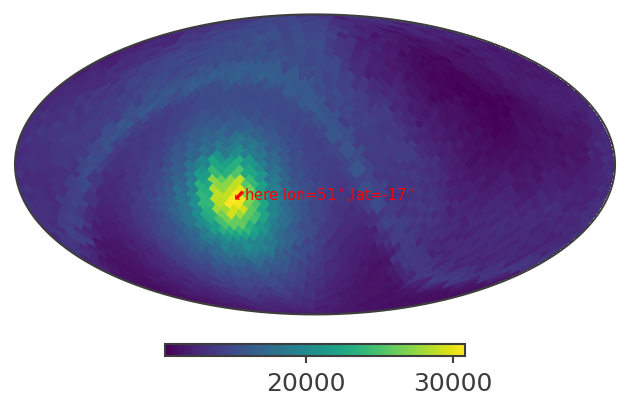

In [36]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, fr"⬋here lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")

# Some tests

## Check scatt_map

In [15]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

with FullDetectorResponse.open(response_path) as response:
    
    scatt_map = ori.get_scatt_map(nside = response.nside, coordsys = 'galactic')
    

(<MollviewSubplot: >, <matplotlib.image.AxesImage at 0x14b6ae330130>)

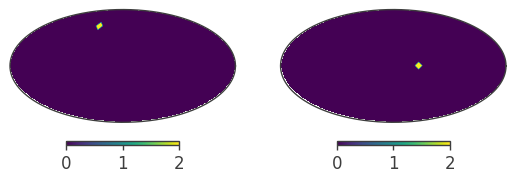

In [16]:
fig,axes = plt.subplots(ncols = 2, subplot_kw = {'projection':'mollview', 'coord':'G'})

scatt_map.project('x').plot(axes[0])
scatt_map.project('y').plot(axes[1])

## Check ei

In [17]:
ei_cds_array = FastTSMap.get_ei_cds_array(hypothesis_coord = hypothesis_coords[233], cds_frame = "galactic",
                                          energy_channel = [2,3], orientation = ori, 
                                          response_path = response_path, spectrum = spectrum)

In [18]:
ei_cds_array.shape

(27648,)

In [20]:
FastTSMap.get_cds_array(data_used, [2,3]).shape

(23040,)

In [21]:
FastTSMap.get_cds_array(bkg_model, [2,3]).shape

(23040,)

In [30]:
with FullDetectorResponse.open(response_path) as response:
    print(repr(response))

FILENAME: '/zfs/astrohe/yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 20.0 deg, 25.0 deg, 30.0 deg, 35.0 deg, 40.0 de

In [28]:
768*30

23040